In [26]:
'''
Baseline second-order MAML
'''

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns 
from math import pi as PI
import random
import torch.nn as nn
import torch
import random
from higher import innerloop_ctx
import warnings
import importlib

warnings.filterwarnings("ignore")

seed = 0 # set seed for reproducibility

#Set random seeds for reproducibility of results 
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# set GPU or CPU depending on available hardware
# help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Available device: {device}")

if device == "cuda:0": 
  # set default so all tensors are on GPU, if available
  # help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
  torch.set_default_tensor_type('torch.cuda.FloatTensor')

# import backbone model, dataset, and code utils
from models import Neural_Network
from constants import *
from utils import *
import analysis_utils
from data import *



Available device: cpu


In [2]:
'''
Create dataset
'''
# specify the number of tasks to sample per meta-set
# note: we end up sampling tasks at random, so sizes are not particularly relevant
# artifact of the way we structured the dataset earlier 
meta_train_size=10000
meta_val_size=1000
meta_test_size=1000
meta_train_eval_size = 20

dataset = RegressionDomain(amp_min=amp_min, amp_max=amp_max, 
                           phase_min=phase_min, phase_max=phase_max, 
                           train_size=meta_train_size, val_size=meta_val_size, test_size=meta_test_size)

meta_val_set = dataset.get_meta_val_batch()
meta_test_set = dataset.get_meta_test_batch()

In [3]:
'''
Handling computation graphs and second-order backprop help and partial inspiration from: 
- https://discuss.pytorch.org/t/how-to-save-computation-graph-of-a-gradient/128286/2 
- https://discuss.pytorch.org/t/when-do-i-use-create-graph-in-autograd-grad/32853/3 
- https://lucainiaoge.github.io/download/PyTorch-create_graph-is-true_Tutorial_and_Example.pdf
- https://www.youtube.com/watch?v=IkDw22a8BDE
- https://discuss.pytorch.org/t/how-to-manually-update-network-parameters-while-keeping-track-of-its-computational-graph/131642/2
- https://discuss.pytorch.org/t/how-to-calculate-2nd-derivative-of-a-likelihood-function/15085/3
- https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html
- https://higher.readthedocs.io/en/latest/toplevel.html

Neural network configuration and helper class functions copied directly from 
-https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb

Note, different ways to refer to the task-specific vs. meta/aggregate updates to the parameters
Sometimes called "inner" and "outer" loop, respectively
Here, refered to as "task_specific" and "agg"/meta" (the latter, for consistency w/ ocariz code)
'''

re_run = False

if re_run: 

    #Instantiate the model network
    model = Neural_Network()
    # move to the current device (GPU or CPU)
    # help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
    model.to(device)

    N = 1 # number of inner loop steps (notation from: https://www.bayeswatch.com/2018/11/30/HTYM/)
    K = 10 # number of samples to draw from the task

    #Used to store the validation losses
    metaLosses = []
    metaValLosses = []

    #Meta-optimizer for the outer loop
    meta_optimizer = torch.optim.Adam(model.parameters(), lr = lr_meta)

    #Inner optimizer, we were doing this by hand previously
    inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)

    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        # store loss over all tasks to then do a large meta-level update of initial params
        # idea/help from video: https://www.youtube.com/watch?v=IkDw22a8BDE
        meta_loss = None

        waves = dataset.get_meta_train_batch(task_batch_size=T)

        #Loop through all of the tasks
        for i, T_i in enumerate(waves): 
            train_eval_info = task_specific_train_and_eval(model, T_i, inner_loop_optimizer, criterion, K=K, N=N)
            held_out_task_specific_loss = train_eval_info[0]
            if meta_loss is None: 
                meta_loss = held_out_task_specific_loss
            else:
                meta_loss += held_out_task_specific_loss

        meta_optimizer.zero_grad()
        meta_loss /= T
        meta_loss.backward()
        meta_optimizer.step()
        metaLosses.append(meta_loss.item())

        # validation 
        val_wave = dataset.get_meta_val_batch(task_batch_size=1)[0]
        val_train_eval_info = task_specific_train_and_eval(model, val_wave, inner_loop_optimizer, criterion, K=K, N=N)
        val_loss = val_train_eval_info[0]
        metaValLosses.append(val_loss.item())

        if epoch % printing_step == 0:
            print("Iter = ", epoch, " Current Loss", np.mean(metaLosses), " Val Loss: ", np.mean(metaValLosses))
            # saving model help from: 
            # https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save(model.state_dict(), "baseline_maml.pt")

Iter =  0  Current Loss 3.4673612117767334  Val Loss:  9.870442390441895
Iter =  500  Current Loss 2.6775107029193412  Val Loss:  2.430931439939254
Iter =  1000  Current Loss 2.099873924052918  Val Loss:  1.8805026992035287
Iter =  1500  Current Loss 1.7561043515990051  Val Loss:  1.5828128975991664
Iter =  2000  Current Loss 1.5516697703183502  Val Loss:  1.399199518937802
Iter =  2500  Current Loss 1.4136964658983513  Val Loss:  1.2836757199442173
Iter =  3000  Current Loss 1.3068037558618841  Val Loss:  1.1862075429227263
Iter =  3500  Current Loss 1.221730532628473  Val Loss:  1.1018269308216915
Iter =  4000  Current Loss 1.1522773598409002  Val Loss:  1.0479288447613488
Iter =  4500  Current Loss 1.0945801315135995  Val Loss:  0.996089236699742
Iter =  5000  Current Loss 1.0457755526264436  Val Loss:  0.9517562343584683
Iter =  5500  Current Loss 1.003231240833614  Val Loss:  0.909834199744544
Iter =  6000  Current Loss 0.9649078257380674  Val Loss:  0.877588324961483
Iter =  6500

In [112]:
# torch.save(model.state_dict(), "./backup_data/baseline_maml.pt")

In [100]:
# torch.save(model.state_dict(), "baseline_maml.pt")

In [4]:
# help from: https://pytorch.org/tutorials/beginner/saving_loading_models.html
model = Neural_Network()
model.load_state_dict(torch.load("baseline_maml.pt"))
criterion = nn.MSELoss()

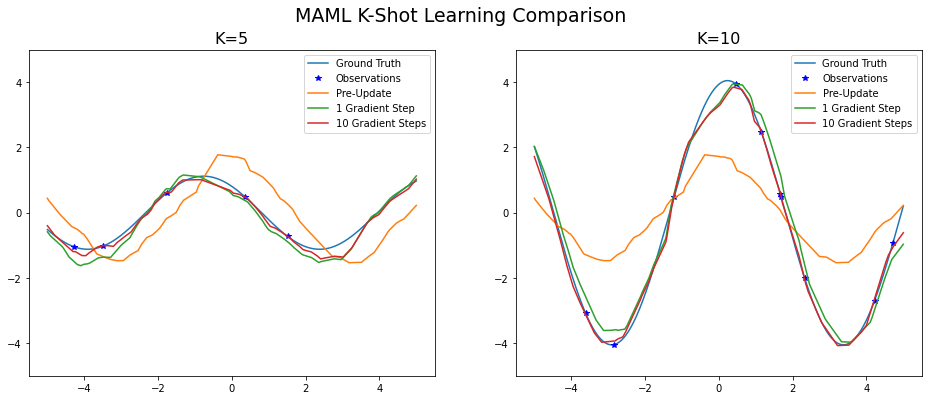

In [5]:
importlib.reload(analysis_utils)

file_tag = "baseline_maml"
plot_lims = [-5.0, 5.0]
analysis_utils.compare_K_shot(model, dataset, criterion, K_vals = [5,10], num_k_shots=10, seed=7,
                              file_tag=file_tag, title="MAML K-Shot Learning Comparison", plot_lims=plot_lims)

Step: 0, Error: 3.0099805807843802, Var: 5.63495282499857
Step: 1, Error: 0.2784293577824719, Var: 0.04588732089335082
Step: 5, Error: 0.08335341039506602, Var: 0.13481166607277625


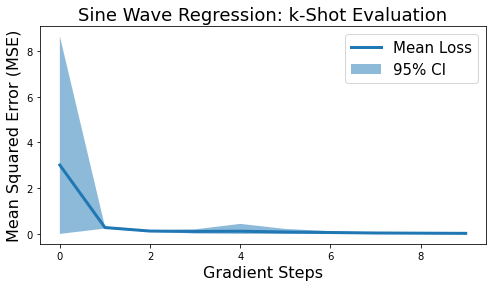

In [6]:
importlib.reload(analysis_utils)

num_k_shots = 10
K = 10
num_eval=1000

res = analysis_utils.k_shot_evaluation(model, dataset, criterion, num_k_shots=num_k_shots, K=K, num_eval=num_eval,
                        file_tag=file_tag, seed=7)

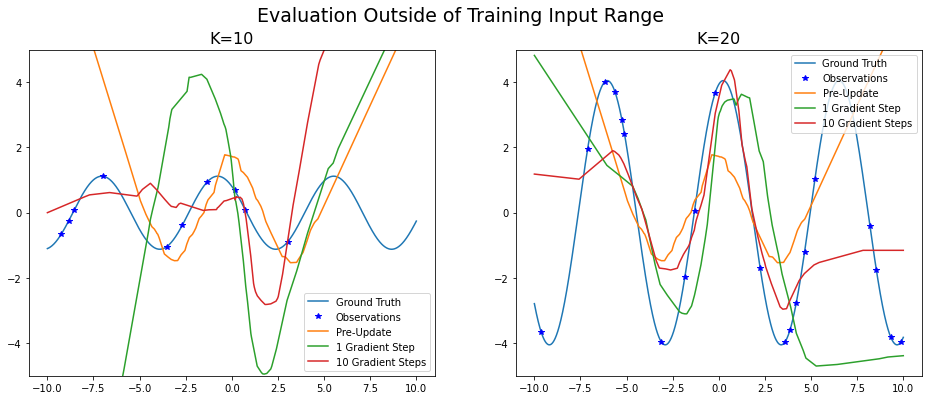

In [48]:
'''
Draw ood samples
'''
importlib.reload(analysis_utils)
wave = dataset.get_meta_test_batch(task_batch_size=1)[0]
ood_range = [-10, 10] # includes some in-dist and ood

file_tag = "ood_x_maml"
plot_lims = [-5.0, 5.0]
analysis_utils.compare_K_shot(model, dataset, criterion, K_vals = [10,20], num_k_shots=11, seed=7,
                              file_tag=file_tag, title="Evaluation Outside of Training Input Range", plot_lims=plot_lims,
                             input_range=ood_range, legend_locs=["lower right", "upper right"])

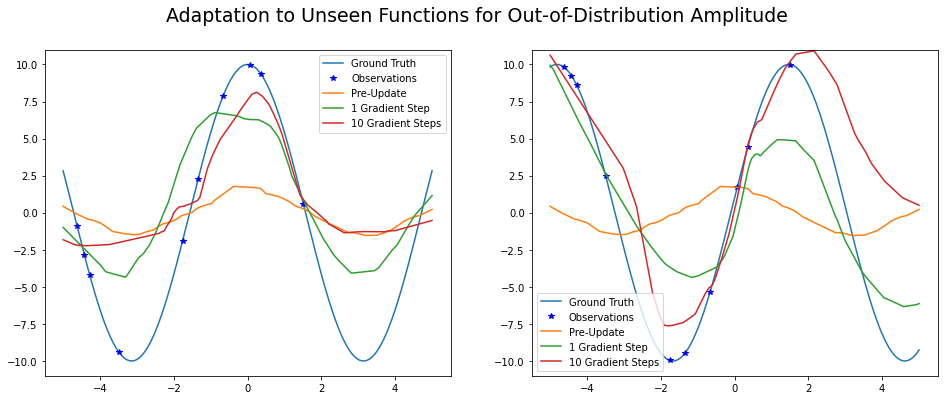

In [111]:
'''
Depict sample amplitude fitting for baseline model
Note, seeds are set for reproducibility
With seeds chosen quasi-randomly to ensure representative, yet compelling, examples for discussion of behavior
'''

importlib.reload(analysis_utils)

example_seed = 7

num_k_shots = 10
extract_task_info = True

K = 10

with_noise=False
noise_dev = 10

phases= [PI/2, 0.1]

ax_size=analysis_utils.ax_size
title_size=analysis_utils.title_size
dpi = analysis_utils.dpi

num_k_shots += 1


fig, axes = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Adaptation to Unseen Functions for Out-of-Distribution Amplitude", fontsize=analysis_utils.title_size + 3)

for idx, phase in enumerate(phases): 

    ax = axes[idx]
    
    torch.manual_seed(example_seed)
    random.seed(example_seed)
    np.random.seed(example_seed)
    
    # ood amplitude, in-dist phase
    test_wave = SineFunction(amplitude = 10, phase = phase)


    # use model returned from earlier optimization
    inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)
    held_out_task_specific_loss, metaTrainLosses, _, task_info = task_specific_train_and_eval(model, test_wave, 
                                                                                              inner_loop_optimizer,
                                                                                              criterion, K, 
                                                                                              num_k_shots, 
                                                                                              extract_task_info,
                                                                                             with_noise=with_noise,
                                                                                             noise_dev=noise_dev)

    true_vals = task_info["gt"]
    func_gt = task_info["gt_func"]
    func_prior = task_info["preds_0"]
    updated_func_single = task_info["preds_1"]
    updated_func_many = task_info[f"preds_{num_k_shots-1}"]

    ax.plot(np.array(func_gt)[:,0], np.array(func_gt)[:,1], label="Ground Truth")
    ax.plot(np.array(true_vals)[:,0], np.array(true_vals)[:,1], '*', label="Observations", color="blue")
    ax.plot(np.array(func_prior)[:,0], np.array(func_prior)[:,1], label="Pre-Update")
    ax.plot(np.array(updated_func_single)[:,0], np.array(updated_func_single)[:,1], label="1 Gradient Step")
    ax.plot(np.array(updated_func_many)[:,0], np.array(updated_func_many)[:,1], label=f"{num_k_shots-1} Gradient Steps")

    ax.legend(fontsize=10)
    
    ax.set_ylim([-11,11])

plt.savefig(f"{analysis_utils.results_dir}amplitude_maml.pdf",dpi=analysis_utils.dpi, bbox_inches="tight")

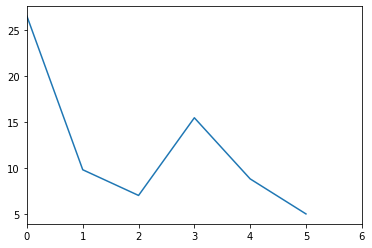

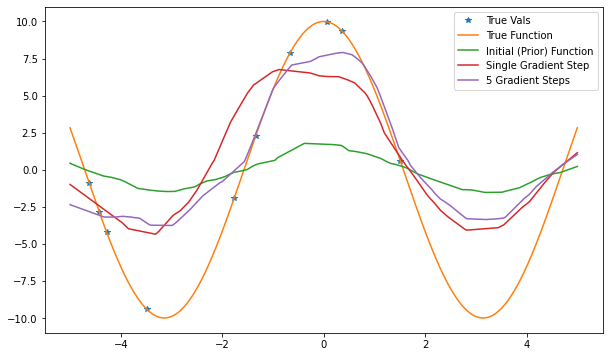

In [75]:
importlib.reload(analysis_utils)
seed = 7 # good
# seed = 11

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

test_wave = SineFunction(amplitude = 10, phase = 0.1)#PI/2)
test_wave = SineFunction(amplitude = 10, phase = PI/2)

num_k_shots = 5 + 1
extract_task_info = True

K = 10

# test_wave = dataset.get_meta_test_batch(task_batch_size=1)[0]

with_noise=False
noise_dev = 10

# use model returned from earlier optimization
inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)
held_out_task_specific_loss, metaTrainLosses, _, task_info = task_specific_train_and_eval(model, test_wave, 
                                                                                          inner_loop_optimizer,
                                                                                          criterion, K, 
                                                                                          num_k_shots, 
                                                                                          extract_task_info,
                                                                                         with_noise=with_noise,
                                                                                         noise_dev=noise_dev)

plt.plot(metaTrainLosses)
plt.xlim([0,num_k_shots])

fig, ax = plt.subplots(figsize=(10,6))
ax_size=16
title_size=18

true_vals = task_info["gt"]
func_gt = task_info["gt_func"]
func_prior = task_info["preds_0"]
updated_func_single = task_info["preds_1"]
updated_func_many = task_info[f"preds_{num_k_shots-1}"]

ax.plot(np.array(true_vals)[:,0], np.array(true_vals)[:,1], '*', label="True Vals")
ax.plot(np.array(func_gt)[:,0], np.array(func_gt)[:,1], label="True Function")
ax.plot(np.array(func_prior)[:,0], np.array(func_prior)[:,1], label="Initial (Prior) Function")
ax.plot(np.array(updated_func_single)[:,0], np.array(updated_func_single)[:,1], label="Single Gradient Step")
ax.plot(np.array(updated_func_many)[:,0], np.array(updated_func_many)[:,1], label=f"{num_k_shots-1} Gradient Steps")

ax.legend()

In [91]:
'''
Boxplot for k-shot performance as a function of amplitude
Run k-shot eval for different amplitude and extract results
'''

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

test_amps = [5, 7, 10, 12]
num_k_shots = 3
num_k_shots += 1

k_labels = ["Pre-Update", "Single Gradient Step", f"{num_k_shots-1} Gradient Steps"]
k_idxs = [0, 1, num_k_shots-1]

num_eval = 100

# maintain ordered list of parameters and results
# for ease of creating data structure
amps = []
pre_update_res = []
single_update_res = []
many_update_res = []
mse_res = []
res_tags = []

for amp in test_amps: 
    all_losses = []
    
    # make waves which have the desired amplitude
    # randomly sample phase in range
    # looping to instantiate tasks idea from: https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb
    # help on generating random numbers in range from: https://pynative.com/python-get-random-float-numbers/
    test_waves = [SineFunction(amplitude = amp, phase = random.uniform(phase_min, phase_max)) for _ in range(num_eval)]
    for test_eval in range(num_eval): 
        test_wave = test_waves[test_eval]

        # use model returned from earlier optimization
        inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)
        held_out_task_specific_loss, metaTrainLosses, _, _ = task_specific_train_and_eval(model, test_wave, inner_loop_optimizer, criterion, K=K, N=num_k_shots)

        all_losses.append(np.array(metaTrainLosses))

    all_losses = np.array(all_losses)
    
    # save for later dataframe
    for k, label in zip(k_idxs, k_labels): 
        amps.extend([amp for _ in range(num_eval)])
    
        mse_res.extend(all_losses[:, k])
    
        res_tags.extend([label for _ in range(num_eval)])

df = pd.DataFrame({"Amplitude": amps, "Mean Squared Error (MSE)": mse_res, "Update Step": res_tags})

df.head(3)

,Amplitude,Mean Squared Error (MSE),Update Step
0,5,9.618299,Pre-Update
1,5,11.484426,Pre-Update
2,5,9.101778,Pre-Update


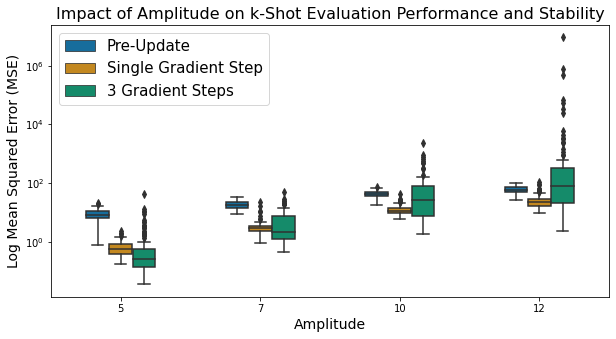

In [99]:
# boxplot help from: https://cmdlinetips.com/2018/03/how-to-make-boxplots-in-python-with-pandas-and-seaborn/
show_df = df#df.loc[df.Amplitude == 10]
fig, ax = plt.subplots(figsize=(10,5))

res = sns.boxplot(y='Mean Squared Error (MSE)', x='Amplitude', 
                 data=show_df, 
                 width=0.5,
                    hue="Update Step",
                 palette="colorblind")

ax.set_yscale('log') # log scale help from: https://stackoverflow.com/questions/773814/plot-logarithmic-axes-with-matplotlib-in-python

ax_size = analysis_utils.ax_size
title_size = analysis_utils.title_size
ax.set_xlabel("Amplitude",fontsize=ax_size)
ax.set_ylabel("Log Mean Squared Error (MSE)",fontsize=ax_size)
ax.set_title("Impact of Amplitude on k-Shot Evaluation Performance and Stability",fontsize=title_size)
ax.legend(fontsize=15)#loc="upper right")
plt.savefig(f"{analysis_utils.results_dir}amplitude_var_maml.pdf",dpi=analysis_utils.dpi, bbox_inches="tight")

shape:  (10,)
shape:  (10,)
shape:  (10,)
shape:  (10,)
shape:  (10,)
shape:  (10,)
shape:  (10,)
shape:  (10,)
shape:  (10,)
shape:  (10,)
shape:  (10, 10)
Step: 0, Error: 3.738843913376331, Var: 7.589241564608783
Step: 1, Error: 0.3000545850023627, Var: 0.024868704371456513
Step: 5, Error: 0.21723983988631518, Var: 0.21561853893682928


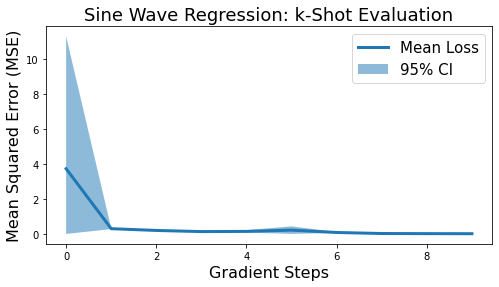

In [82]:
importlib.reload(analysis_utils)

num_k_shots = 10
K = 10
num_eval=10

res = analysis_utils.k_shot_evaluation(model, dataset, criterion, num_k_shots=num_k_shots, K=K, num_eval=num_eval,
                        file_tag=file_tag, seed=7)